# Libraries


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split

# Load the Dataset

In [50]:
df = pd.read_csv('data/cars.csv')
df = df.drop(columns=["url","Ötürücü","Şəhər","Yerlərin sayı","Sürətlər qutusu","Rəng","Sahiblər","Marka","Ban növü","Qəzalı"])

print("Columns:", df.columns.tolist())

missing_values = df.isnull().sum()
print(missing_values)

Columns: ['Model', 'Yeni', 'Mühərrik', 'Yürüş', 'price', 'Vəziyyəti', 'Hansı bazar üçün yığılıb', 'Buraxılış ili']
Model                         0
Yeni                          0
Mühərrik                      0
Yürüş                         0
price                         0
Vəziyyəti                     0
Hansı bazar üçün yığılıb    932
Buraxılış ili                 0
dtype: int64


# Preperation Of the Dataset

### Mühərrik Column

In [51]:
if "Mühərrik" in df.columns:
    parts = df["Mühərrik"].str.split(" / ", expand=True)

    while parts.shape[1] < 3:
        parts[parts.shape[1]] = None  

    df["engine_raw"] = parts[0]
    df["hp_raw"] = parts[1]
    df["fuel"] = parts[2]

    mask_elektro = df["fuel"].isna() & df["hp_raw"].str.contains("elektro", case=False, na=False)
    df.loc[mask_elektro, "fuel"] = df.loc[mask_elektro, "hp_raw"]
    df.loc[mask_elektro, "hp_raw"] = df.loc[mask_elektro, "engine_raw"]
    df.loc[mask_elektro, "engine_raw"] = None

    def parse_engine(val):
        if pd.isna(val):
            return None
        val = val.strip().lower()
        if "l" in val:
            try:
                return float(val.replace(" l", "").replace("l", "").strip())
            except:
                return None
        if "sm3" in val:
            try:
                return float(val.replace(" sm3", "").replace("sm3", "").strip()) / 1000
            except:
                return None
        return None

    df["L"] = df["engine_raw"].apply(parse_engine)

    def parse_hp(val):
        if pd.isna(val):
            return None
        match = re.search(r"(\d+)", val)
        return float(match.group(1)) if match else None  

    df["a.g."] = df["hp_raw"].apply(parse_hp)

    df["fuel"] = df["fuel"].str.strip().str.capitalize()

df = df.drop(columns=["Mühərrik", "engine_raw", "hp_raw"])


### Yürüş Column

In [52]:
if "Yürüş" in df.columns:
    df["Yürüş"] = (
        df["Yürüş"]
        .str.replace(" km", "", regex=False)
        .str.replace(" ", "", regex=False)
    )
    df["Yürüş"] = pd.to_numeric(df["Yürüş"], errors="coerce").astype("Int64")

### Vəziyyəti Column

In [53]:
if "Vəziyyəti" in df.columns:
    df["rənglənib"] = df["Vəziyyəti"].str.contains("rənglənib", case=False, na=False).astype(int)
df = df.drop(columns=["Vəziyyəti"])


### Price Column

In [54]:
if "price" in df.columns:
    df["price"] = (
        df["price"]
        .str.replace(" AZN", "", regex=False)
        .str.replace(" ", "", regex=False)
    )
    df["price"] = pd.to_numeric(df["price"], errors="coerce").astype("Int64")


### Yeni Column

In [55]:
if "Yeni" in df.columns:
    df["Yeni"] = df["Yeni"].map({"Bəli": 1, "Xeyr": 0})

### price Column

In [56]:
df["price"] = df["price"].replace("", pd.NA)
df = df.dropna(subset=["price"])


## Replacing small NaN values with 0/Unknown

In [57]:
df["Hansı bazar üçün yığılıb"] = df["Hansı bazar üçün yığılıb"].replace("", "Unknown").fillna("Unknown")


In [58]:
df["L"] = df["L"].fillna(0)
df["fuel"] = df["fuel"].fillna("Unknown")
df["a.g."] = df["a.g."].fillna(0)

In [59]:
missing_values = df.isnull().sum()
print(missing_values)

Model                       0
Yeni                        0
Yürüş                       0
price                       0
Hansı bazar üçün yığılıb    0
Buraxılış ili               0
fuel                        0
L                           0
a.g.                        0
rənglənib                   0
dtype: int64


In [60]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 4171 entries, 2 to 5255
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Model                     4171 non-null   object 
 1   Yeni                      4171 non-null   int64  
 2   Yürüş                     4171 non-null   Int64  
 3   price                     4171 non-null   Int64  
 4   Hansı bazar üçün yığılıb  4171 non-null   object 
 5   Buraxılış ili             4171 non-null   int64  
 6   fuel                      4171 non-null   object 
 7   L                         4171 non-null   float64
 8   a.g.                      4171 non-null   float64
 9   rənglənib                 4171 non-null   int64  
dtypes: Int64(2), float64(2), int64(3), object(3)
memory usage: 366.6+ KB


,Yeni,Yürüş,price,Buraxılış ili,L,a.g.,rənglənib
count,4171.000000,4171.0,4171.0,4171.00000,4171.000000,4171.000000,4171.000000
mean,0.192280,161995.773196,28216.960201,2014.27859,2.017334,180.427475,0.072405
std,0.394139,140077.007013,29921.776074,8.49915,1.164402,93.515714,0.259188
min,0.000000,0.0,1500.0,1950.00000,0.000000,0.000000,0.000000
25%,0.000000,36542.0,14600.0,2009.00000,1.500000,122.000000,0.000000
50%,0.000000,157716.0,22900.0,2015.00000,1.800000,170.000000,0.000000
75%,0.000000,239668.0,33200.0,2022.00000,2.200000,215.000000,0.000000
max,1.000000,1300000.0,410000.0,2025.00000,13.000000,1500.000000,1.000000


# Graphs of Numeric Columns

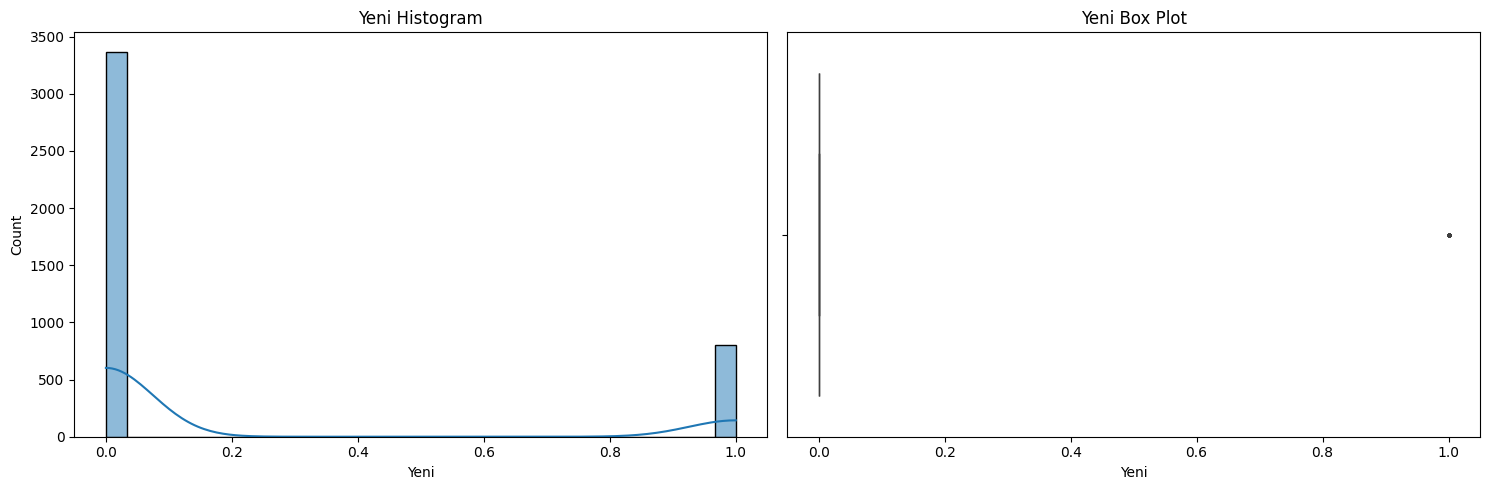

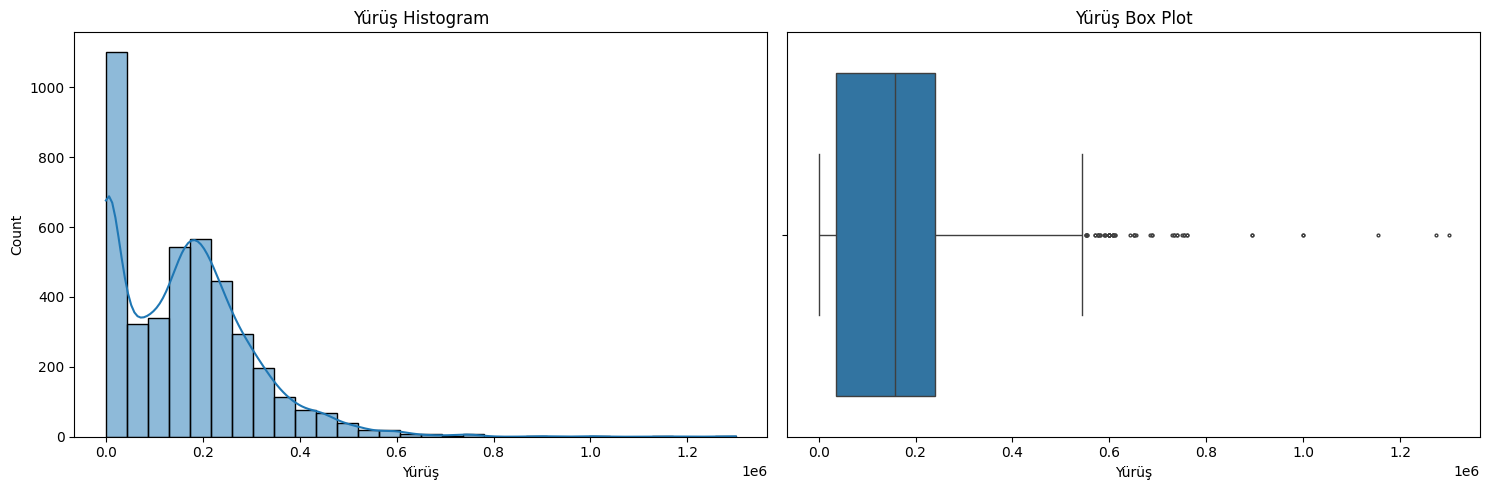

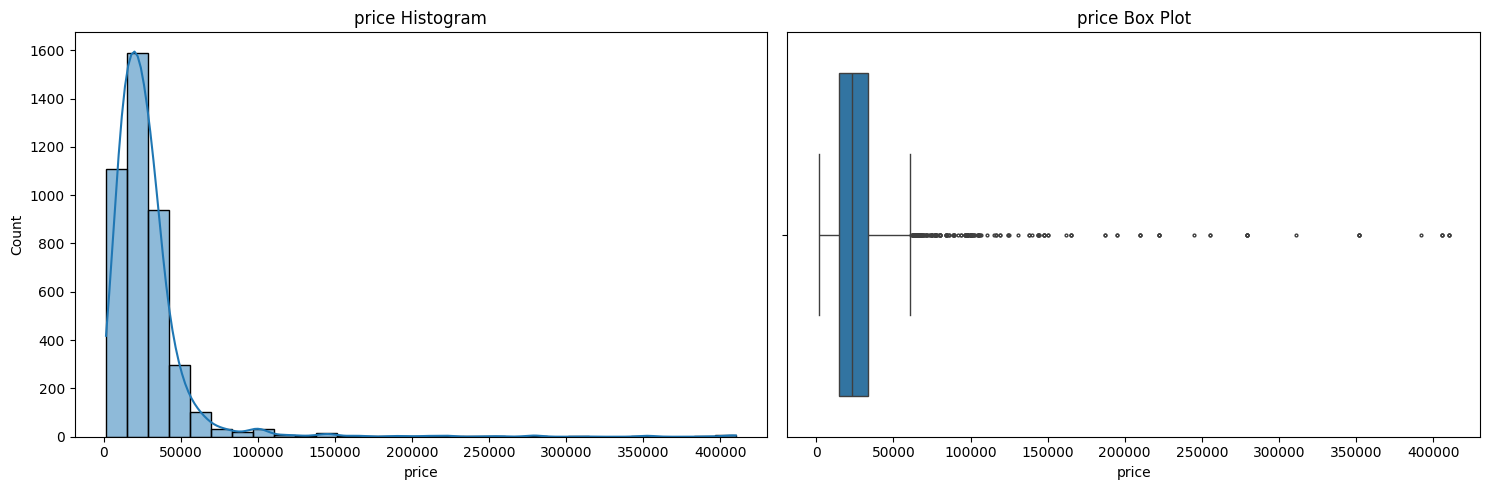

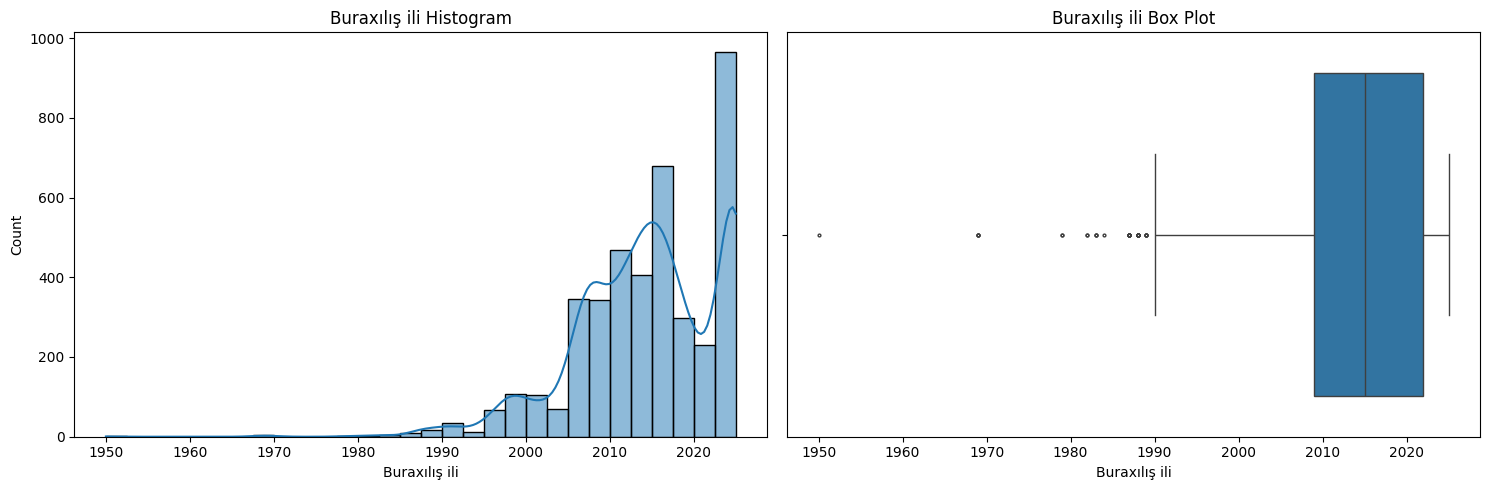

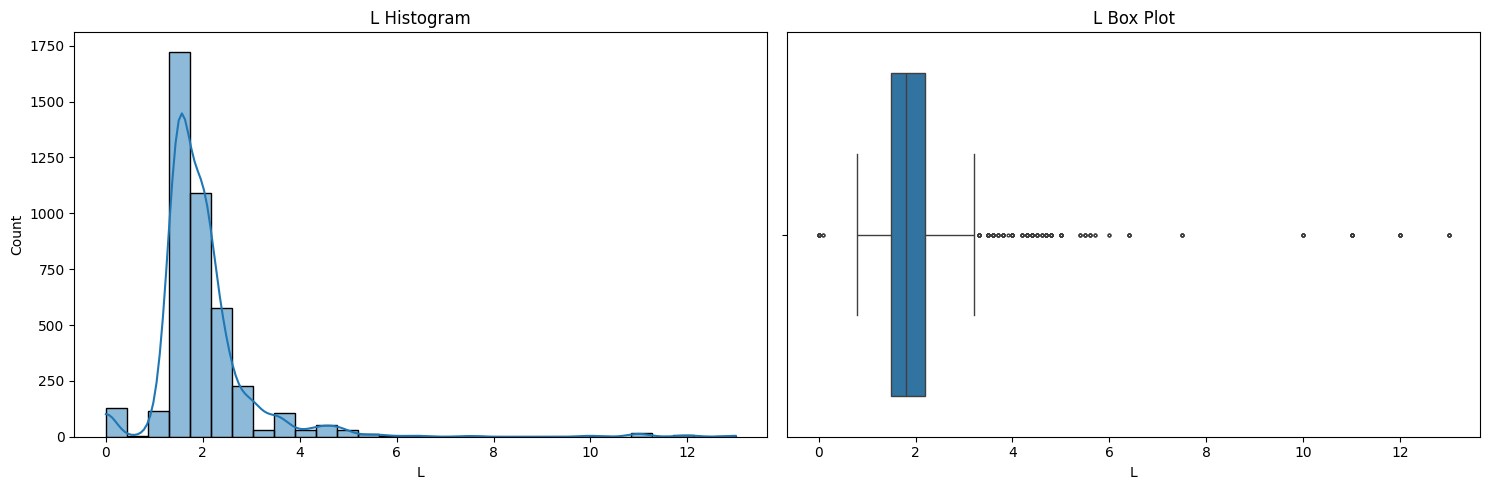

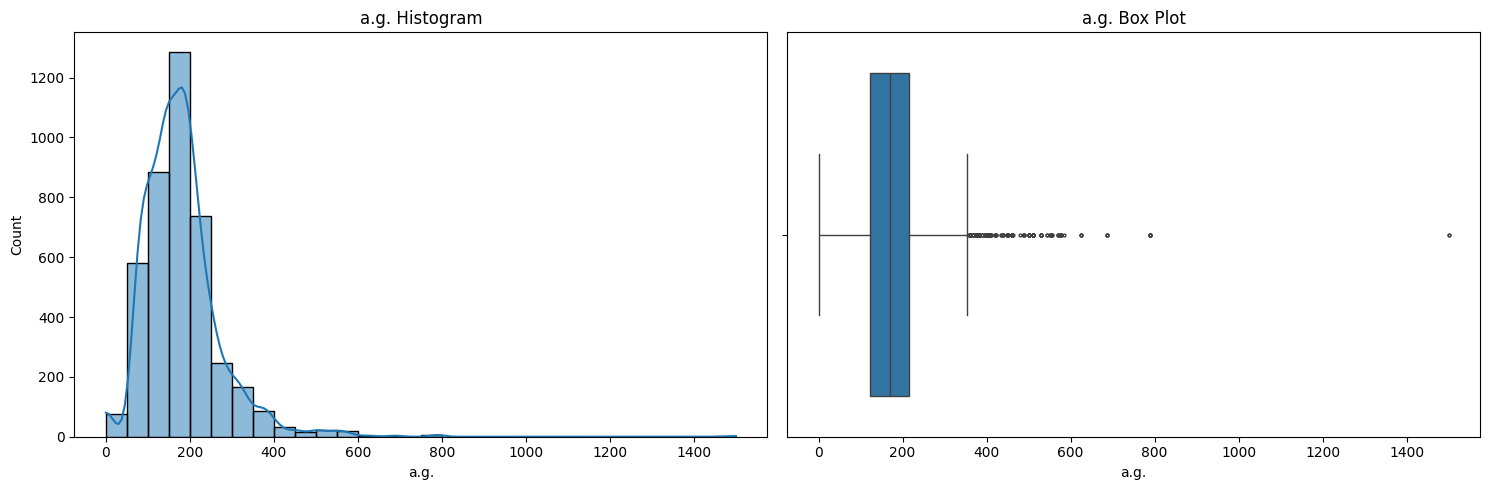

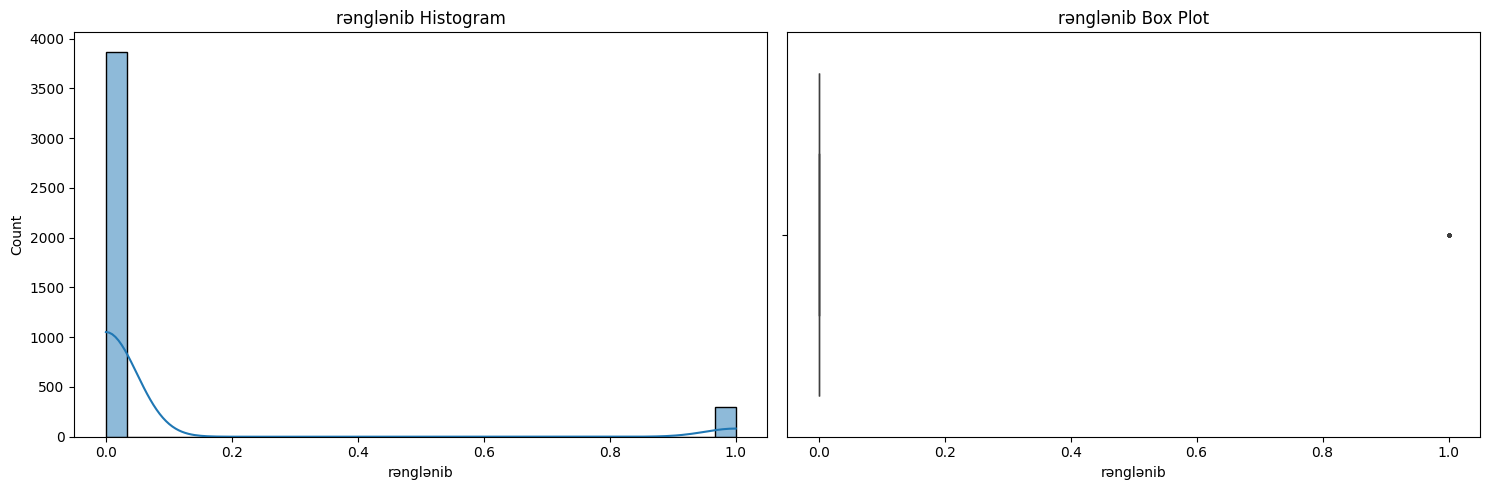

In [61]:
numeric_cols = df.select_dtypes(include=np.number).columns
for col in numeric_cols:
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"{col} Histogram")
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col], fliersize=2)
    plt.title(f"{col} Box Plot")
    plt.tight_layout()
    plt.show()

# Graphs of Object Columns

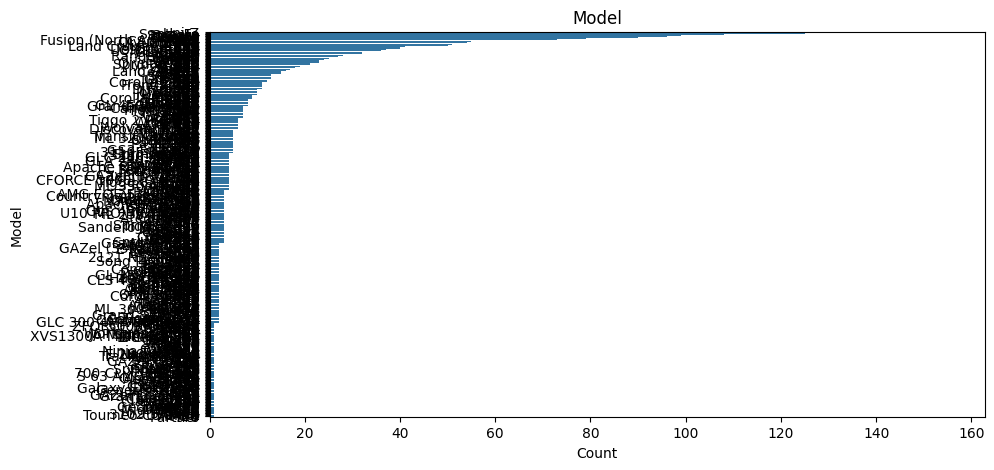

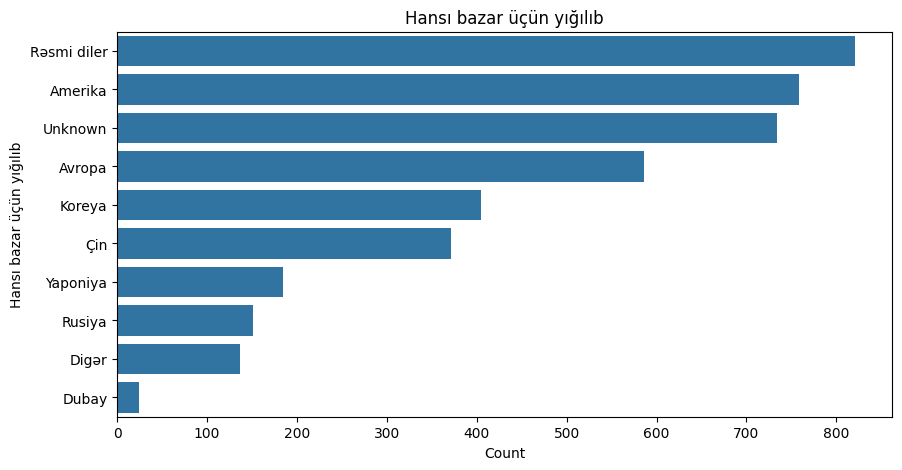

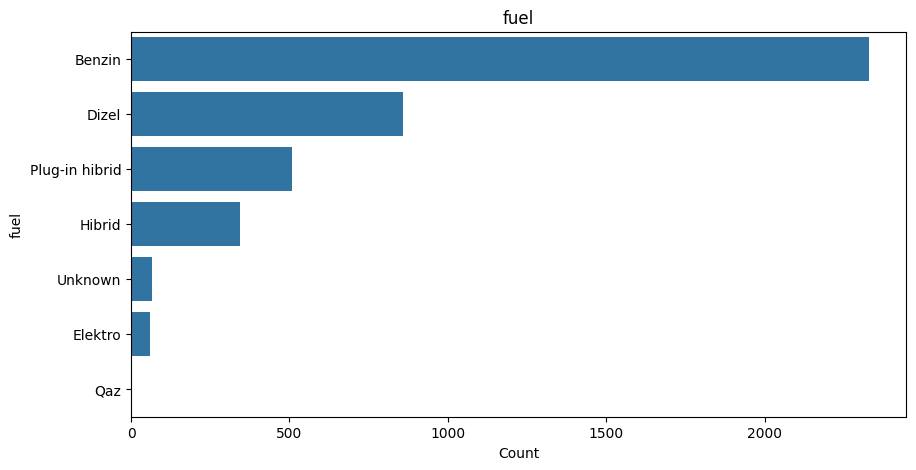

In [62]:
categorical_cols = df.select_dtypes(include='object').columns

for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(y=df[col], order = df[col].value_counts().index)
    plt.title(col)
    plt.xlabel("Count")
    plt.ylabel(col)
    plt.show()

# Encoding Categorical Columns

In [63]:
df_encoded = pd.get_dummies(df, columns=["fuel", "Hansı bazar üçün yığılıb"], drop_first=True)

# Target encoding

In [64]:
df_encoded["price"] = pd.to_numeric(df_encoded["price"], errors="coerce")
df_encoded = df_encoded.dropna(subset=["price"])

X = df_encoded.drop(columns=["price"])
y = df_encoded["price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model_mean_price = X_train.join(y_train).groupby("Model")["price"].mean()

X_train["Model_enc"] = X_train["Model"].map(model_mean_price)
X_test["Model_enc"] = X_test["Model"].map(model_mean_price)

global_mean_price = y_train.mean()
X_test["Model_enc"] = X_test["Model_enc"].fillna(global_mean_price)

X_train = X_train.drop(columns=["Model"])
X_test = X_test.drop(columns=["Model"])


# Models

In [74]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor

models = {
    "Extra Trees": ExtraTreesRegressor(n_estimators=1000, random_state=42),
    "Hist Gradient Boosting": HistGradientBoostingRegressor(max_iter=500, random_state=42),
    "XGBoost": XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_estimators=1000,
        subsample=1.0,
        min_child_weight=1,
        max_depth=7,
        learning_rate=0.2,
        gamma=0.4,
        colsample_bytree=1.0
    )
}

results = []

for name, m in models.items():
    m.fit(X_train, y_train)

    preds = m.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    results.append({"Model": name, "MAE": mae, "R²": r2})

results_df = pd.DataFrame(results).sort_values(by="MAE")

print(results_df)


                    Model          MAE        R²
0             Extra Trees  1910.740434  0.784670
2                 XGBoost  1982.977295  0.766207
1  Hist Gradient Boosting  2898.490857  0.768439


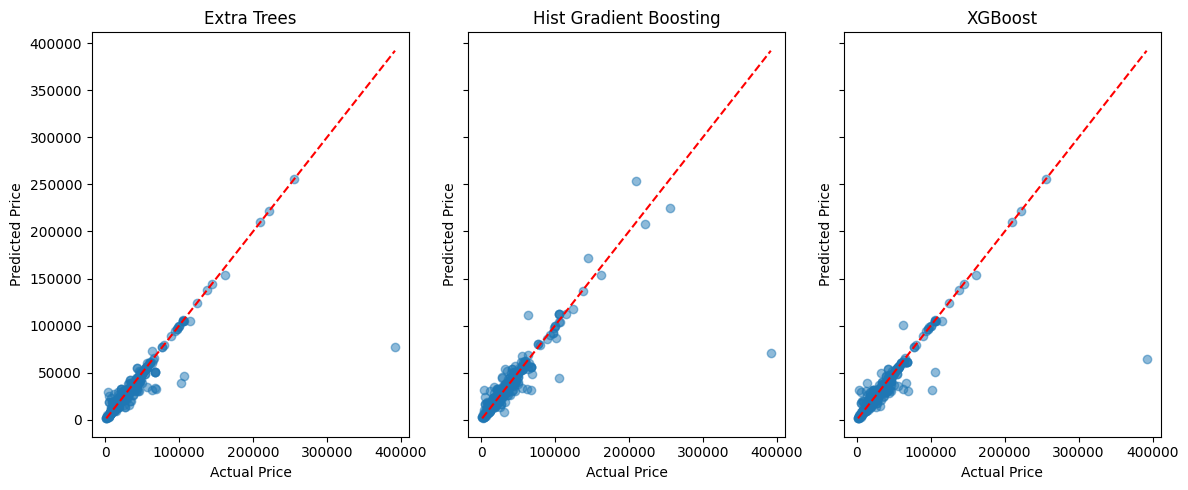

In [72]:
import matplotlib.pyplot as plt

n_models = len(models)
n_cols = 3
n_rows = (n_models + 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows), sharey=True)
axes = axes.flatten() 

for i, (name, m) in enumerate(models.items()):
    preds = m.predict(X_test)

    axes[i].scatter(y_test, preds, alpha=0.5)
    axes[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")  
    axes[i].set_title(name)
    axes[i].set_xlabel("Actual Price")
    axes[i].set_ylabel("Predicted Price")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [67]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor

xgb_model = XGBRegressor(subsample=1.0, min_child_weight=1, max_depth=7,
                        learning_rate=0.2, gamma=0.4, colsample_bytree=1.0,
                        random_state=42, n_estimators=500)
xgb_model.fit(X_train, y_train)

indices = np.random.choice(len(X_test), size=10, replace=False)

samples = X_test.iloc[indices]
actual_prices = y_test.iloc[indices].values

predicted_prices = xgb_model.predict(samples)

comparison = pd.DataFrame({
    "Row Index": indices,
    "Actual Price": actual_prices,
    "Predicted Price": predicted_prices.round(2),
    "Difference": (actual_prices - predicted_prices).round(2)
})

print(comparison)


   Row Index  Actual Price  Predicted Price  Difference
0        675         16800     16861.300781       -61.3
1         72         17500     17536.300781       -36.3
2         83         28400     30720.800781     -2320.8
3        455         15900     15915.160156      -15.16
4        704         96700     96700.976562       -0.98
5        794         30500     30396.939453      103.06
6        802         11000     11835.870117     -835.87
7        610         21500     21505.599609        -5.6
8        661         26500     26565.599609      -65.61
9        417         23700     23707.599609        -7.6


In [ ]:
import joblib

joblib.dump(xgb_model, "models/xgboost_model.pkl")

joblib.dump(X_train.columns.tolist(), "models/feature_columns.pkl")

joblib.dump({
    "model_mean_price": model_mean_price,
    "global_mean_price": global_mean_price
}, "models/model_encoding.pkl")


['models/model_encoding.pkl']